In [1]:
from time import sleep
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import importlib

import optical_network_game.game_gym
importlib.reload(optical_network_game.game_gym)
from optical_network_game.game_gym import *

from optical_network_game.requests import generateRequests
from optical_network_game.topology_generation import createPresetTopology

from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.callbacks import BaseCallback

pygame 2.0.3 (SDL 2.0.16, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level.
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # # New best model, you could save the agent here
              # if mean_reward > self.best_mean_reward:
              #     self.best_mean_reward = mean_reward
              #     # Example for saving best model
              #     if self.verbose > 0:
              #       print(f"Saving new best model to {self.save_path}")
              #     self.model.save(self.save_path)

        return True

In [ ]:
class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)
        # self.cum_bp = []
    
    def _on_step(self) -> bool:
        block_ep = self.locals["infos"][0].get('bp')
        length_ep = self.locals["infos"][0].get('avg_length')
        self.logger.record('blocking_ratio', block_ep)
        self.logger.record('average_route_length', block_ep)
        return True

    # def _on_rollout_end(self) -> None:
    #     self.logger.record('blocking_ratio', mean(self.cum_bp))

    #     # reset
    #     self.cum_bp = []
    #     pass

In [3]:
import os
# Create log dir
log_dir = os.path.join(os.getcwd(), "tmp_2/")
os.makedirs(log_dir, exist_ok=True)

In [4]:
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=log_dir)
tensor_callback = TensorboardCallback()

# create model

nodeList, linkList = createTestTopology()
requestList = generateRequests(nodeList, 30)

user = User()
env = game_gym(nodeList, linkList, requestList, user)
eveon = Monitor(env, log_dir)

# check_env(eveon, warn=True)
model = DQN('MlpPolicy', eveon, verbose=1, buffer_size=100000, device='cuda', 
learning_starts=50000, exploration_fraction=0.5, learning_rate=0.0001,
gamma=0.8, tensorboard_log='./dqn_tensorboard_2/')

Using cuda device
Wrapping the env in a DummyVecEnv.


In [ ]:
# train
timesteps = 10000000
model.learn(total_timesteps=timesteps, callback=[callback, tensor_callback])
model.save("DQNEveon_sw")

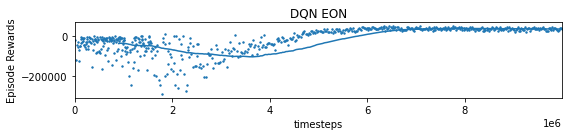

In [6]:
# Plot rewards
plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "DQN EON")
plt.show()

In [6]:
#nodeList, linkList = createTestTopology()
nodeList, linkList = createPresetTopology(Preset="VSNL")
#requestList = generateRequests(nodeList, 30)
requestList, traffic_load = generateRequests_Dynamic_Traffic(nodeList, numberOfRequests=30, req_interval=2, hold_time=10)

user = User()
env = game_gym(nodeList, linkList, requestList, user)

VSNL Topology Selected
Traffic load is: 5.0


In [7]:
# test
final_model = 'DQNEveon_sw'
best_model = 'tmp/best_model.zip'
model = DQN.load(final_model, env=env, device='cpu')

obs = env.reset()

while True :
    # clear_output(wait=True)
    action, states_ = model.predict(obs, deterministic=True )
    # action = 6
    obs, rewards, dones, info = env.step(action)
    # plt.imshow(obs)
    # plt.show()
    #print(action)
    if dones == True:
        print(env.reward)

        # with open('info.json', 'w') as outfile:
        #     json.dump(info, outfile)

        env.reset()

    env.render()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


ValueError: Observation spaces do not match: Box([1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0], [5 4 1 6 4 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1], (51,), int8) != Box([1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0], [5 4 1 6 4 2 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1], (87,), int8)